<a href="https://colab.research.google.com/github/alphas7/Santander-Customer-Satisfaction/blob/master/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip -uq "/content/drive/My Drive/Santander_Customer_Satisfaction/pickle_files.zip" -d "/content/"

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
from sklearn.manifold import TSNE
import sklearn
from sklearn import metrics
from sklearn import cluster
from sklearn.manifold import TSNE
import scipy
import random
from tqdm import tqdm

In [60]:
train = pd.read_pickle('pickle_files/train_1.pkl')
test = pd.read_pickle('pickle_files/test_1.pkl')

In [61]:
X_test = test.copy()
X_train = train.copy()
X_train.shape,X_test.shape

((76020, 144), (75818, 143))

# No. of zeros

In [62]:
def add_feature_no_zeros(train=X_train,test=X_test):
    """
    Add feature which tells the no. of occurences of zeros,nonzeros across a datapoint
    """
    col = [k for k in train.columns if k!='TARGET']
    for df in [train,test]:
        df['no_zeros'] = (df.loc[:,col]==0).sum(axis=1).values
        df['no_nonzeros'] = (df.loc[:,col]!=0).sum(axis=1).values

In [63]:
def add_feature_no_zeros_keyword(keyword,train=X_train,test=X_test):
    """
    Add feature which tells the no. of occurences of zeros,nonzeros across a datapoint
    for a specific keyword
    """
    col = [k for k in train.columns if keyword in k]
    for df in [train,test]:
        df['no_zeros_'+k] = (df.loc[:,col]==0).sum(axis=1).values
        df['no_nonzeros_'+k] = (df.loc[:,col]!=0).sum(axis=1).values

In [64]:
#adding no. of zeros feature
add_feature_no_zeros()
X_train.shape,X_test.shape

((76020, 146), (75818, 145))

In [65]:
keywords = ['saldo' , 'ind', 'num', 'imp']
for k in keywords:
  add_feature_no_zeros_keyword(k)
X_train.shape,X_test.shape

((76020, 154), (75818, 153))

Taking average values for each unique values of a categorical feature for all 'saldo' and 'imp' features

In [66]:
def average_col(col,features,train=X_train,test=X_test):
  """
  Gets the average numerical values of features for each category in 'col' feature
  and add it as feature 
  """
  for df in [train,test]:
    unique_values = df[col].unique()
    
    for feature in features:
      avg_value=[]
      for value in unique_values:
        avg = df.loc[df[col]==value,feature].mean() #taking average for each category for feature col
        avg_value.append(avg)
      avg_dict = dict(zip(unique_values,avg_value))
      new_col = 'avg_'+col+'_'+feature
      df[new_col] = np.zeros(df.shape[0])
      for value in unique_values:
        df.loc[df[col]==value,new_col] = avg_dict[value]

In [67]:
%%time
#we will be taking average columns for saldo and imp with categorical columns being the ones that have between 50 and 200 unqiue values
features = [i for i in X_train.columns if ('saldo' in i) & ('no_zeros' not in i)]
features.extend([i for i in X_train.columns if ('imp' in i) & ('no_zeros' not in i)])
columns = [i for i in X_train.columns if (X_train[i].nunique()<=210) & (X_train[i].nunique()>50)] #categorical features

for col in tqdm(columns):
  average_col(col,features)

100%|██████████| 19/19 [09:53<00:00, 31.24s/it]

CPU times: user 9min 46s, sys: 6.77 s, total: 9min 53s
Wall time: 9min 53s


# K-Means Clustering

In [17]:
def stdzation(train,test):
  """
  apply standardization to features
  for train and test using scale
  for all columns
  """
  col=[i for i in train.columns if (i!='TARGET') & (i!='ID')]
  scaler = sklearn.preprocessing.StandardScaler()
  train.loc[:,col]= scaler.fit_transform(train.loc[:,col])
  test.loc[:,col] = scaler.transform(test.loc[:,col])

In [69]:
stdization(X_train,X_test)

In [68]:
#https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
# We will use silhouete score to determine the best k. silhouette score : highest score shows best k.

kminmax = [2,10]
k = np.arange(kminmax[0],kminmax[1]+1,2)
k

array([ 2,  4,  6,  8, 10])

In [69]:
X =X_train.drop(['TARGET','ID'],axis=1)
sil_score = []
sse = []
for i in tqdm(k):
  kmeans = cluster.KMeans(n_clusters=i,n_jobs=-1,verbose=2,random_state=100)
  kmeans.fit(X)
  labels = kmeans.predict(X)
  score = metrics.silhouette_score(X,labels,random_state=100)
  sil_score.append(score)


100%|██████████| 5/5 [55:18<00:00, 663.62s/it]


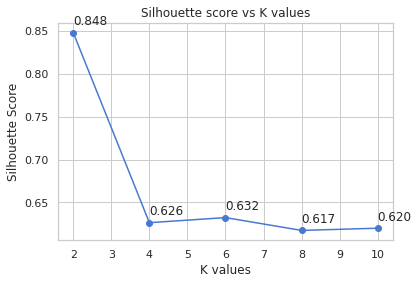

In [70]:
plt.title('Silhouette score vs K values')
sns.lineplot(x=k,y=sil_score)
plt.scatter(x=k,y=sil_score)
for i, score in enumerate(sil_score):
    plt.annotate("%.3f"%(score), (k[i], score+0.009))
plt.xlabel('K values')
plt.ylabel('Silhouette Score')
plt.show()

We can see that silhouette score is highest for k=2. We can add k means cluster values for 2,4,6,8 and 10 as features.

In [70]:
def add_kmeans_cluster(ncluster=[2,4,6,8,10],train=X_train,test=X_test):
  """
  Function add Kmeans cluster value as features for n in ncluster
  """
  X_tr = train.drop(['TARGET','ID'],axis=1).copy()
  X_te = test.drop(['ID'],axis=1).copy()
  for n in ncluster:
    print("for n=%i:"%(n))
    feat_name = 'Kmeans_'+str(n)
    kmeans = cluster.KMeans(n_clusters=n,n_jobs=-1,verbose=2,random_state=100)
    train[feat_name] = kmeans.fit_predict(X_tr)
    test[feat_name] = kmeans.predict(X_te)


In [71]:
%%time
add_kmeans_cluster()

for n=2:
for n=4:
for n=6:
for n=8:
for n=10:
CPU times: user 12.2 s, sys: 3.06 s, total: 15.3 s
Wall time: 34min 29s


# Feature Selection

# Remove highly correlated features and low correlated features with TARGET.

In [72]:
def remove_corr_var(train=X_train,test=X_test,target_threshold = 10**-3,within_threshold=0.95):
  """
  Remove correlated features that have low correlation with target 
  and have high correlation with each other (keeping one)
  """
  #removing all low correlated variables with target
  initial_feature = train.shape[1]
  corr = train.drop("ID",axis=1).corr().abs()
  corr_target = pd.DataFrame(corr['TARGET']).sort_values(by='TARGET')
  threshold=target_threshold
  feat_df =corr_target[(corr_target['TARGET'])<=threshold]
  print("There are %i features that have a correlation values less than %.3f with 'TARGET'. We will remove all of this."\
        %(feat_df.shape[0],threshold))
  print("Removing.........")

  for df in [train,test]:
    df.drop(feat_df.index,axis=1,inplace=True)


  #reomving highly correlated features(keeping one)
  #https://www.dezyre.com/recipes/drop-out-highly-correlated-features-in-python
  corr.drop('TARGET',axis=1,inplace=True)
  corr.drop('TARGET',axis=0,inplace=True)
  corr.drop(feat_df.index,axis=1,inplace=True)
  corr.drop(feat_df.index,inplace=True)
  threshold = within_threshold
  upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool)) #getting upper traingle of correlation matrix
  column = [col for col in upper.columns if any(upper[col]>threshold)] #getting all columns that have high correlation with one of the features
  print("There are %i features that have high correlation with another feature with threshold being kept as %.3f and above. We will remove all of this."\
        %(len(column),threshold))
  print("Removing.........")
  for df in [train,test]:
    df.drop(column,axis=1,inplace=True)

  print("The features were changed from %i to %i. %i features were removed."%(initial_feature,train.shape[1],initial_feature-train.shape[1]))  


In [73]:
%%time
remove_corr_var()

There are 46 features that have a correlation values less than 0.001 with 'TARGET'. We will remove all of this.
Removing.........
There are 553 features that have high correlation with another feature with threshold being kept as 0.950 and above. We will remove all of this.
Removing.........
The features were changed from 957 to 358. 599 features were removed.
CPU times: user 2min 32s, sys: 906 ms, total: 2min 33s
Wall time: 2min 33s


In [4]:
# X_train.to_pickle('/content/drive/My Drive/Santander_Customer_Satisfaction/X_train_2.pkl')
# X_test.to_pickle('/content/drive/My Drive/Santander_Customer_Satisfaction/X_test_2.pkl')
X_train=pd.read_pickle('/content/drive/My Drive/Santander_Customer_Satisfaction/X_train_2.pkl')
X_test = pd.read_pickle('/content/drive/My Drive/Santander_Customer_Satisfaction/X_test_2.pkl')
X_train.shape,X_test.shape

((76020, 358), (75818, 357))

# Applying log transformation to 'saldo' and 'imp' features 

In [5]:
def apply_log(train,test,column):
  """
  apply log transformation to all features in col variable
  """
  tr = train.copy()
  te = test.copy()
  for df in [tr,te]:
    for col in column:
      df.loc[df[col]>=0,col] = np.log(df.loc[df[col]>=0,col].values)
  
  return tr,te

In [6]:
features = [i for i in X_train.columns if (('saldo' in i)|('imp' in i))&((X_train[i].values>=0).all())]
X_train_l,X_test_l = apply_log(X_train,X_test,features)

# One Hot Encoding

In [7]:
#getting all columns with less than or equal to 10 nunique values
cat_col = []
for col in X_train.columns:
  if (X_train[col].nunique()<=10) & (col!='TARGET') & (X_train[col].nunique()>2) & ('Kmeans' not in col):
    cat_col.append(col)
print("There are %i columns which have less than or equal to 10 and greater than 2 number of unique values. \nWe will create \
new datasets which use one hot encoding,\
response encoding and also leaving the columns as it is."%(len(cat_col)))

There are 16 columns which have less than or equal to 10 and greater than 2 number of unique values. 
We will create new datasets which use one hot encoding,response encoding and also leaving the columns as it is.


In [8]:
def one_hot_encoding(col,train=X_train,test=X_test):
  """
  one hot encodes all the features in col array in all X dataset
  """
  ohe = sklearn.preprocessing.OneHotEncoder(sparse=True,handle_unknown='ignore')
  ohe.fit(train.loc[:,col])
  feature_names = list(ohe.get_feature_names(input_features=col))
  features = list(train.drop(col,axis=1).columns)
  features.extend(feature_names)

  #train
  df = train.copy()
  temp = ohe.transform(df[cat_col])
  df.drop(col,axis=1,inplace=True)
  train = pd.DataFrame(scipy.sparse.hstack([df.values,temp]).toarray(),columns=features).copy()
  train = train.loc[:,~train.columns.duplicated(keep='first')] #removing duplicated columns (duplicated columsn were seen)


  #test
  df = test.copy()
  temp = ohe.transform(df[cat_col])
  df.drop(col,axis=1,inplace=True)
  features.remove('TARGET')
  test = pd.DataFrame(scipy.sparse.hstack([df.values,temp]).toarray(),columns=features).copy()
  test = test.loc[:,~test.columns.duplicated(keep='first')] #removing duplicated columns (duplicated columsn were seen)

  return train,test

In [9]:
X_train_ohe,X_test_ohe = one_hot_encoding(cat_col)
X_train_l_ohe,X_test_l_ohe = one_hot_encoding(cat_col,X_train_l,X_test_l)
X_train_ohe.shape,X_test_ohe.shape,X_train_l_ohe.shape,X_test_l_ohe.shape

((76020, 445), (75818, 444), (76020, 445), (75818, 444))

# Response Encoding

In [10]:
def response_encoding_return(df,column,target,alpha=5000):
    """
    Here we are using response encoding with laplace smoothing to a categorical column
    and transform the respective column in train,test,val datasets.
    Here we will be repeating the values of each category alpha times.
    the function will return the response encoding values of each categorical value in that column
    """
    unique_values = set(df[column].values)
    dict_values = {}
    for value in unique_values:
        total = len(df[df[column]==value])
        sum_promoted = len(df[(df[column]==value) & df[target]==1])
        dict_values[value] = np.round((sum_promoted+alpha)/(total+alpha*len(unique_values)),2)
    return dict_values

In [11]:
def response_encoding(df,test_df,column,target='TARGET',alpha=5000):
    """
    Here we are using response encoding with laplace smoothing to a categorical column
    and transform the respective column in train,test,val datasets.
    Here we will be repeating the values of each category alpha times.
    """
    feature = column+'_1'
    feature_ = column + '_0'
    unique_values = set(df[column].values) #all unique values in that categorical column
    dict_values = {} #storing the response encoding values for target=1
    dict_values_ = {} #storing the response encoding values for target=0
    for value in unique_values:
        total = len(df[df[column]==value]) #the total no. of datapoints with 'value' catgeory
        sum_promoted = len(df[(df[column]==value) & df[target]==1]) #no. of all datapoints with category being 'value' and target==1
        sum_unpromoted = total-sum_promoted #no. of all datapoints with category being 'value' and target==0
        dict_values[value] = np.round((sum_promoted+alpha)/(total+alpha*len(unique_values)),2) #storing the obtained result in a dictionary
        dict_values_[value] = np.round((sum_unpromoted+alpha)/(total+alpha*len(unique_values)),2)
    dict_values['unknown']=0.5 #unknown categories that are not seen in train will be assigned a score of 0.5
    dict_values_['unknown'] = 0.5
    df[feature]=(df[column].map(dict_values)).values
    df[feature_] = (df[column].map(dict_values_)).values
    df.drop(column,axis=1,inplace=True)

    unique_values_test = set(test_df[column].values)
    test_df[column]=test_df[column].apply(lambda x: 'unknown' if x in (unique_values_test-unique_values) else x )
    test_df[feature] = (test_df[column].map(dict_values)).values
    test_df[feature_] = (test_df[column].map(dict_values_)).values
    test_df.drop(column,axis=1,inplace=True)

In [12]:
# finding the best alpha
random.seed(100)
ran_in = random.randint(0,10)
col = [col for col in cat_col if X_train[col].nunique()>3][ran_in]
col
print('Feature: "%s"'%(col))
for alpha in [100,500,1000,2500,5000,10000]:
  print('for alpha %i:%s'%(alpha,response_encoding_return(X_train,col,"TARGET",alpha=alpha)))

Feature: "num_var5_0"
for alpha 100:{0.16140601649391956: 0.04, 4.731270215327344: 0.13, 9.301134414160769: 0.2, 18.440862811827618: 0.2, -4.408458182339505: 0.09}
for alpha 500:{0.16140601649391956: 0.04, 4.731270215327344: 0.18, 9.301134414160769: 0.2, 18.440862811827618: 0.2, -4.408458182339505: 0.13}
for alpha 1000:{0.16140601649391956: 0.05, 4.731270215327344: 0.19, 9.301134414160769: 0.2, 18.440862811827618: 0.2, -4.408458182339505: 0.15}
for alpha 2500:{0.16140601649391956: 0.06, 4.731270215327344: 0.19, 9.301134414160769: 0.2, 18.440862811827618: 0.2, -4.408458182339505: 0.17}
for alpha 5000:{0.16140601649391956: 0.08, 4.731270215327344: 0.2, 9.301134414160769: 0.2, 18.440862811827618: 0.2, -4.408458182339505: 0.19}
for alpha 10000:{0.16140601649391956: 0.1, 4.731270215327344: 0.2, 9.301134414160769: 0.2, 18.440862811827618: 0.2, -4.408458182339505: 0.19}


In [13]:
random.seed(1000)
ran_in = random.randint(0,10)
col = [col for col in cat_col if X_train[col].nunique()>3][ran_in]
# finding the best alpha
print('Feature: "%s"'%(col))
for alpha in [100,500,1000,2500,5000,10000]:
  print('for alpha %i:%s'%(alpha,response_encoding_return(X_train,col,"TARGET",alpha=alpha)))

Feature: "num_var26"
for alpha 100:{-0.14219773333156485: 0.04, 33.26579423799687: 0.11, 4.6303725482867835: 0.08, 9.402942829905133: 0.1, 42.81093480123357: 0.11, 14.17551311152348: 0.11, 18.94808339314183: 0.11, 52.35607536447027: 0.11, 23.72065367476018: 0.11}
for alpha 500:{-0.14219773333156485: 0.04, 33.26579423799687: 0.11, 4.6303725482867835: 0.1, 9.402942829905133: 0.11, 42.81093480123357: 0.11, 14.17551311152348: 0.11, 18.94808339314183: 0.11, 52.35607536447027: 0.11, 23.72065367476018: 0.11}
for alpha 1000:{-0.14219773333156485: 0.05, 33.26579423799687: 0.11, 4.6303725482867835: 0.1, 9.402942829905133: 0.11, 42.81093480123357: 0.11, 14.17551311152348: 0.11, 18.94808339314183: 0.11, 52.35607536447027: 0.11, 23.72065367476018: 0.11}
for alpha 2500:{-0.14219773333156485: 0.06, 33.26579423799687: 0.11, 4.6303725482867835: 0.11, 9.402942829905133: 0.11, 42.81093480123357: 0.11, 14.17551311152348: 0.11, 18.94808339314183: 0.11, 52.35607536447027: 0.11, 23.72065367476018: 0.11}
for 

Looking at the above two features, the best alpha was found to be alpha=100. Each category had highest different response encoding values for this alpha.

In [14]:
#response encoding features
alpha=100
X_train_re = X_train.copy()
X_test_re = X_test.copy()
X_train_l_re = X_train_l.copy()
X_test_l_re = X_test_l.copy()
for col in tqdm(cat_col):
  response_encoding(X_train_re,X_test_re,col,alpha=alpha)
  response_encoding(X_train_l_re,X_test_l_re,col,alpha=alpha)

X_train_re.shape,X_test_re.shape,X_train_l_re.shape,X_test_l_re.shape

100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


((76020, 373), (75818, 372), (76020, 373), (75818, 372))

# Standardization

In [18]:
datasets = [(X_train,X_test),(X_train_re,X_test_re),(X_train_ohe,X_test_ohe),(X_train_l,X_test_l),\
            (X_train_l_re,X_test_l_re), (X_train_l_ohe,X_test_l_ohe)] #l represents log transformed


for train,test in datasets:
  stdzation(train,test)

# TSNE visualization

In [19]:
np.random.seed(5000)

In [117]:
%%time
X = X_train.drop(['ID','TARGET'],axis=1).copy()
p = 20
n=2
tsne = TSNE(n,perplexity=p,n_jobs=-1)
X_embedded = tsne.fit_transform(X)

CPU times: user 1h 32min 27s, sys: 3.29 s, total: 1h 32min 30s
Wall time: 47min 9s


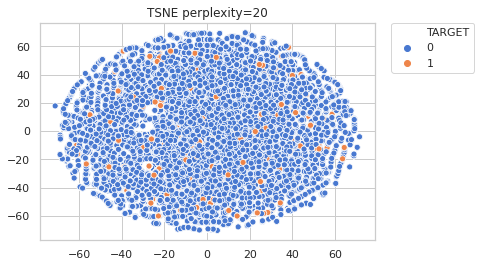

In [118]:
sns.scatterplot(X_embedded[:,0],X_embedded[:,1],hue=X_train['TARGET'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
plt.title("TSNE perplexity=%i"%(p))
plt.show()

In [119]:
%%time
X = X_train.drop(['ID','TARGET'],axis=1).copy()
p = 50
n=2
tsne = TSNE(n,perplexity=p,n_jobs=-1)
X_embedded = tsne.fit_transform(X)

CPU times: user 1h 46min 7s, sys: 5.57 s, total: 1h 46min 13s
Wall time: 54min 15s


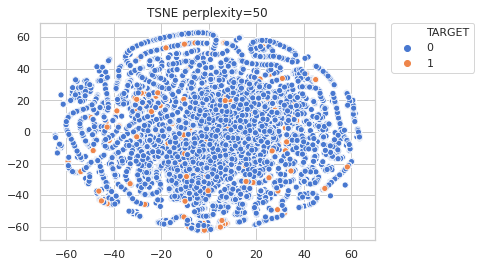

In [120]:
sns.scatterplot(X_embedded[:,0],X_embedded[:,1],hue=X_train['TARGET'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
plt.title("TSNE perplexity=%i"%(p))
plt.show()

# PCA visualization

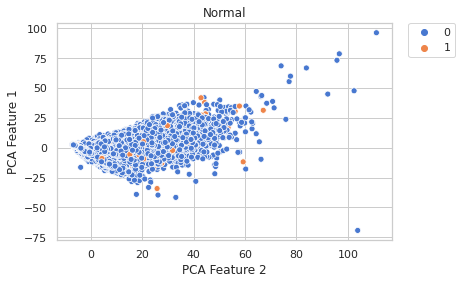

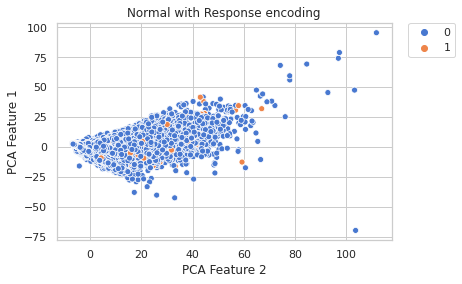

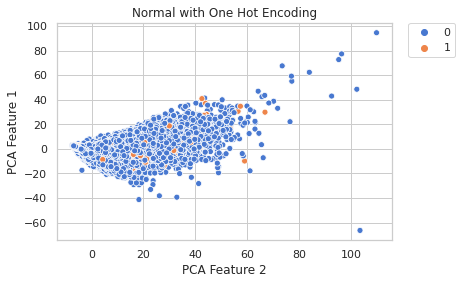

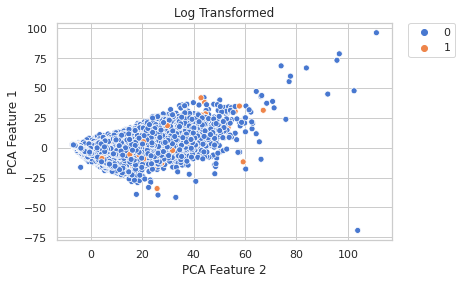

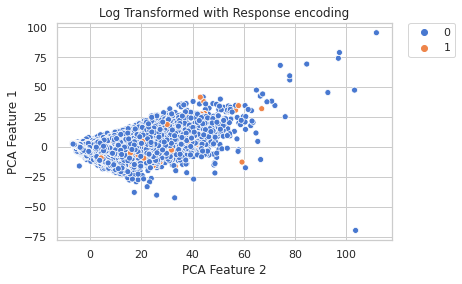

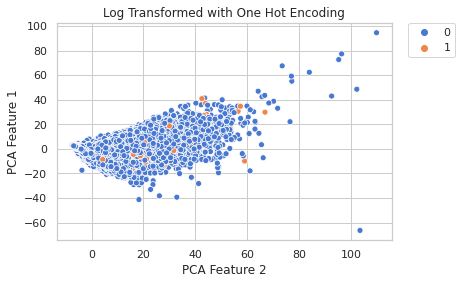

CPU times: user 28.8 s, sys: 1.62 s, total: 30.4 s
Wall time: 21.5 s


In [20]:
%%time
datasets = [(X_train,X_test),(X_train_re,X_test_re),(X_train_ohe,X_test_ohe),(X_train_l,X_test_l),\
            (X_train_l_re,X_test_l_re), (X_train_l_ohe,X_test_l_ohe)] #l represents log transformed
datasets_labels=["Normal",'Normal with Response encoding',"Normal with One Hot Encoding",\
                 "Log Transformed",'Log Transformed with Response encoding',"Log Transformed with One Hot Encoding"]
# cat_col.extend('ID','TARGET')
for i,(train,test) in enumerate(datasets):
  pca = sklearn.decomposition.PCA(n_components=2)
  X = train.drop(['ID','TARGET'],axis=1).copy()
  X_embedded = pca.fit_transform(X)
  sns.scatterplot(X_embedded[:,0],X_embedded[:,1],hue=X_train['TARGET'].values)
  plt.ylabel("PCA Feature 1")
  plt.xlabel("PCA Feature 2")
  plt.title(datasets_labels[i])
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
  plt.show()


In [21]:
def add_pca_features(train,test,n=2):
  """
  Add pca values as features with n resulting components
  """
  pca = sklearn.decomposition.PCA(n_components=n)
  feat_names = ['pca_'+str(i) for i in range(n)]

  #train
  X= train.drop(["ID","TARGET"],axis=1)
  X_embedded=pca.fit_transform(X)
  for i,feat in enumerate(feat_names):
    train[feat] = X_embedded[:,i]

  #test
  X= test.drop("ID",axis=1)
  X_embedded=pca.fit_transform(X)
  for i,feat in enumerate(feat_names):
    test[feat] = X_embedded[:,i]


In [22]:
n=2
for train,test in datasets:
  add_pca_features(train,test,n)
  stdzation(train,test) 

In [23]:
datasets = [(X_train,X_test),(X_train_re,X_test_re),(X_train_ohe,X_test_ohe),(X_train_l,X_test_l),\
            (X_train_l_re,X_test_l_re), (X_train_l_ohe,X_test_l_ohe)]
print("The final no. features are:")
for i,(train,test) in enumerate(datasets):
  print("%s:\t%i"%(datasets_labels[i],test.shape[1]))

The final no. features are:
Normal:	359
Normal with Response encoding:	374
Normal with One Hot Encoding:	446
Log Transformed:	359
Log Transformed with Response encoding:	374
Log Transformed with One Hot Encoding:	446


In [25]:
for i,(train,test) in enumerate(datasets):
  file = (datasets_labels[i]+'.pkl')
  train.to_pickle("/content/drive/My Drive/Santander_Customer_Satisfaction/train_"+file)
  test.to_pickle("/content/drive/My Drive/Santander_Customer_Satisfaction/test_"+file)